In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-05-19 10:35:45.376714: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

# Imports

In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



2024-05-24 10:38:16.326160: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 0


2024-05-24 10:38:17.657388: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-24 10:38:17.657418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 8a9ef2a50632
2024-05-24 10:38:17.657425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 8a9ef2a50632
2024-05-24 10:38:17.657575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-05-24 10:38:17.659175: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-05-24 10:38:17.660986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4


In [3]:
from orbit_generation.data import load_memmap_array, save_data
from orbit_generation.processing import resample_3d_array
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space, plot_combined_latent_space
from orbit_generation.model import get_optimizer

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-05-24 10:38:35.838425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Parameters

In [5]:
data_path = r"/orbit-generation/data/1p_dataset_em.npy"
labels_path = r"/orbit-generation/data/1p_dataset_em_labels.npy"
folder_experiments = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 7,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    }
}

## Create Experiment Folder

In [7]:
# Extract relevant parameters
model_name = params['model_name']
data_used = params['data_used']

# Combine the remaining parameters into a single string to form the last subdirectory name
# Excluding 'model_name' and 'data_used' since they're used in higher-level directories
other_params = f"{params['latent_dim']}_{params['feature_dim']}_{params['seq_len']}_{params['batch_size']}_{params['epochs']}_{params['optimizer']['name']}_{params['optimizer']['learning_rate']}"

# Construct the full path for the experiment directory
experiment_folder = os.path.join(folder_experiments, model_name, data_used, other_params)

# Create the directory structure
os.makedirs(experiment_folder, exist_ok=True)

# Now you can use 'experiment_folder' to save files related to this particular experiment
print(f"Experiment directory created: {experiment_folder}")

Experiment directory created: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001


In [8]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Imports

In [8]:
data = load_memmap_array(data_path)
data.shape

(36071, 7, 1500)

In [9]:
labels = np.load(labels_path)
labels.shape

(36071,)

## Interpolation

In [10]:
data = resample_3d_array(data=data, axis=2, target_size=params['seq_len'])
data.shape

(36071, 7, 300)

## Shuffle

In [11]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = labels[indices]

## Transpose

In [12]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [13]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(36071, 300, 7)

# Generation

## Define Architecture

In [15]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [16]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-05-19 10:36:17.473867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/1128 [..............................] - ETA: 58s - loss: 2587.2850 - reconstruction_loss: 2069.9504 - kl_loss: 10.6996WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0298s). Check your callbacks.


1128/1128 [==============================] - 61s 52ms/step - loss: 461.9566 - reconstruction_loss: 205.0325 - kl_loss: 19.8368
Epoch 2/25
1128/1128 [==============================] - 59s 52ms/step - loss: 71.3952 - reconstruction_loss: 37.1304 - kl_loss: 18.7075
Epoch 3/25
1128/1128 [==============================] - 59s 52ms/step - loss: 47.1761 - reconstruction_loss: 28.5606 - kl_loss: 16.4931
Epoch 4/25
1128/1128 [==============================] - 59s 52ms/step - loss: 53.6791 - reconstruction_loss: 31.8647 - kl_loss: 15.7322
Epoch 5/25
1128/1128 [==============================] - 59s 52ms/step - loss: 27.4733 - reconstruction_loss: 14.0921 - kl_loss: 13.2447
Epoch 6/25
1128/1128 [==============================] - 59s 52ms/step - loss: 29.4299 - reconstruction_loss: 18.6575 - kl_loss: 13.2991
Epoch 7/25
1128/1128 [==============================] - 59s 52ms/step - loss: 27.6634 - reconstruction_loss: 19.9942 - kl_loss: 12.5903
Epoch 8/25
1128/1128 [==============================] - 5

## Save Model

In [15]:
# Define full paths for the encoder and decoder
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')

In [18]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

wandb.save('encoder.h5')
wandb.save('decoder.h5')
wandb.save('generation.npy')

INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/decoder/assets


[]

In [19]:
"""
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
"""

'\nencoder = tf.keras.models.load_model(encoder_save_path)\ndecoder = tf.keras.models.load_model(decoder_save_path)\n\n# Assuming encoder and decoder have been defined as part of the architecture setup\nvae = tsgm.models.cvae.BetaVAE(encoder, decoder)\n'

## Predict

In [20]:
x_decoded = vae.predict(scaled_data)

1128/1128 [==============================] - 16s 14ms/step


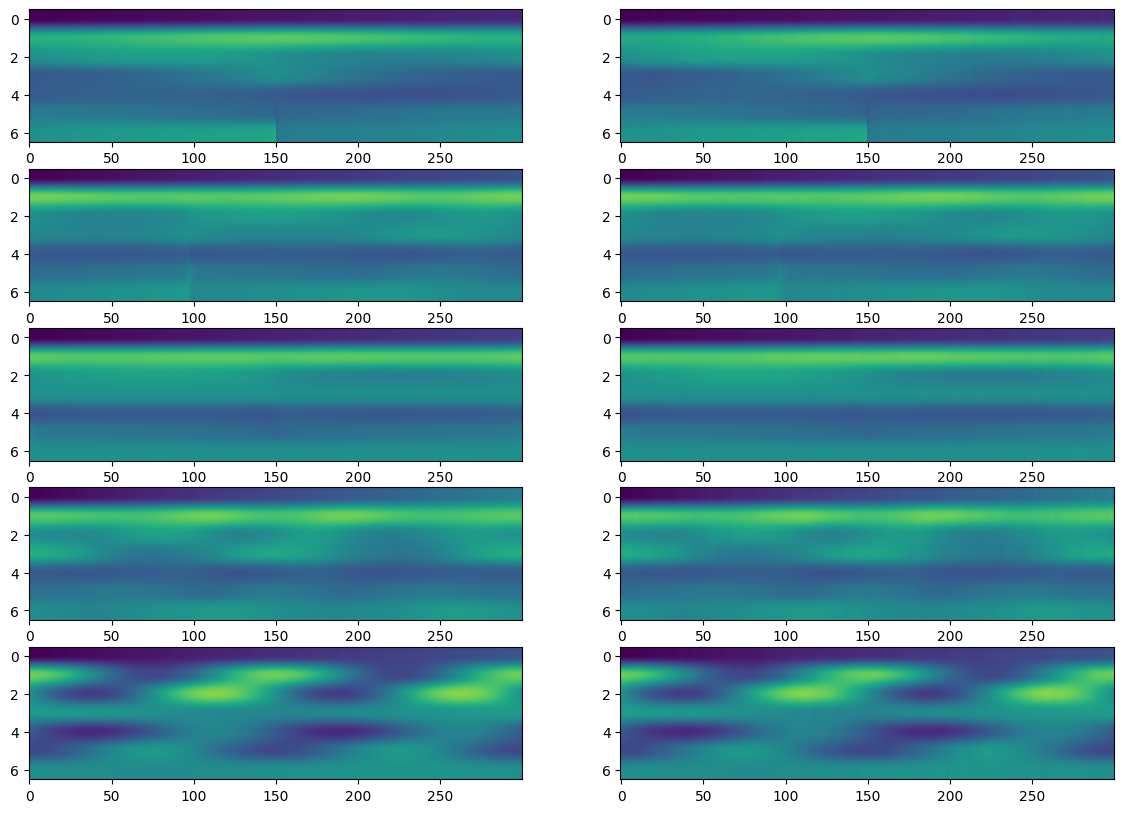

In [21]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=5)

## Generate

In [22]:
# generation = vae.generate(int(data.shape[0]*0.01))
generation = vae.generate(100)
generation.shape

TensorShape([100, 300, 7])

In [18]:
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
print(generated_data_path)

../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/generated_data.npy


In [24]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 7])

In [19]:
# generation = np.load(generated_data_path)

# Analysis

## Visualization

In [26]:
no_time_generation = inverted_generation[:,:,1:]
no_time_generation.shape

TensorShape([100, 300, 6])

In [27]:
display_generation = np.transpose(no_time_generation, (0, 2, 1))

In [28]:
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')

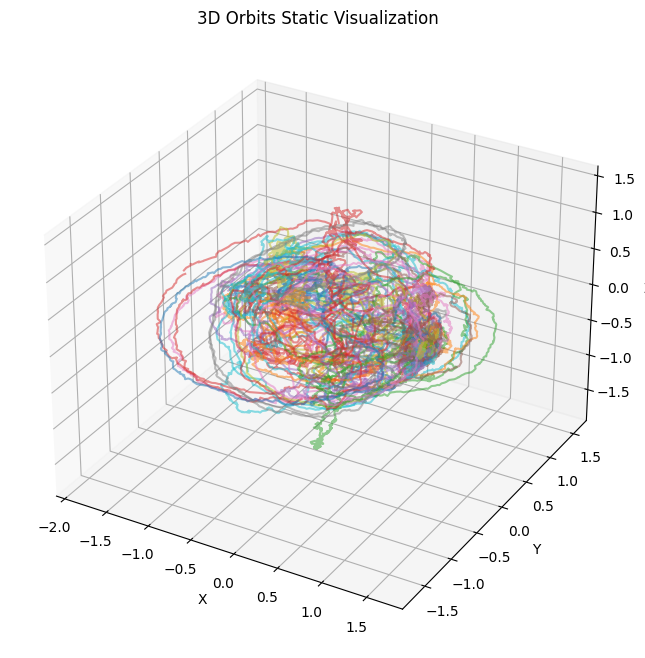

In [29]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

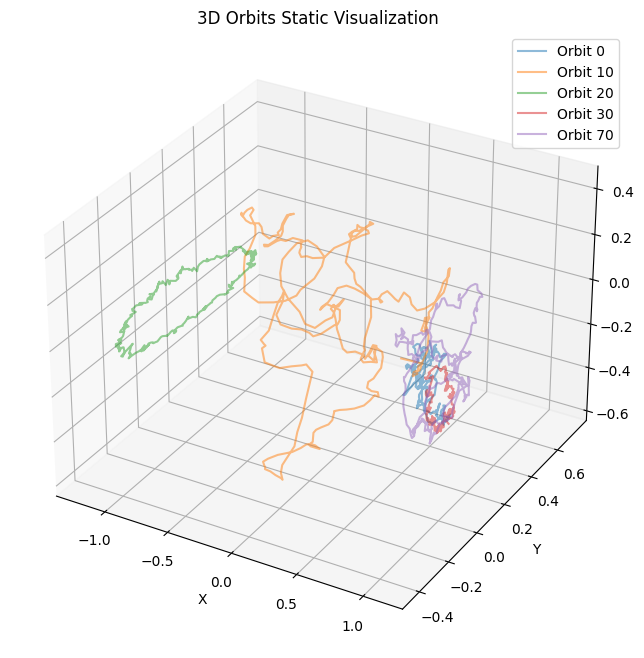

In [30]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,70], save_path=static_some_orbit_path)

In [31]:
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/generated_orbits.html


## Coverage

In [20]:
data.shape

(36071, 7, 300)

In [22]:
inverted_ordered_generation = np.transpose(data, (0, 2, 1))
inverted_ordered_generation.shape

(36071, 300, 7)

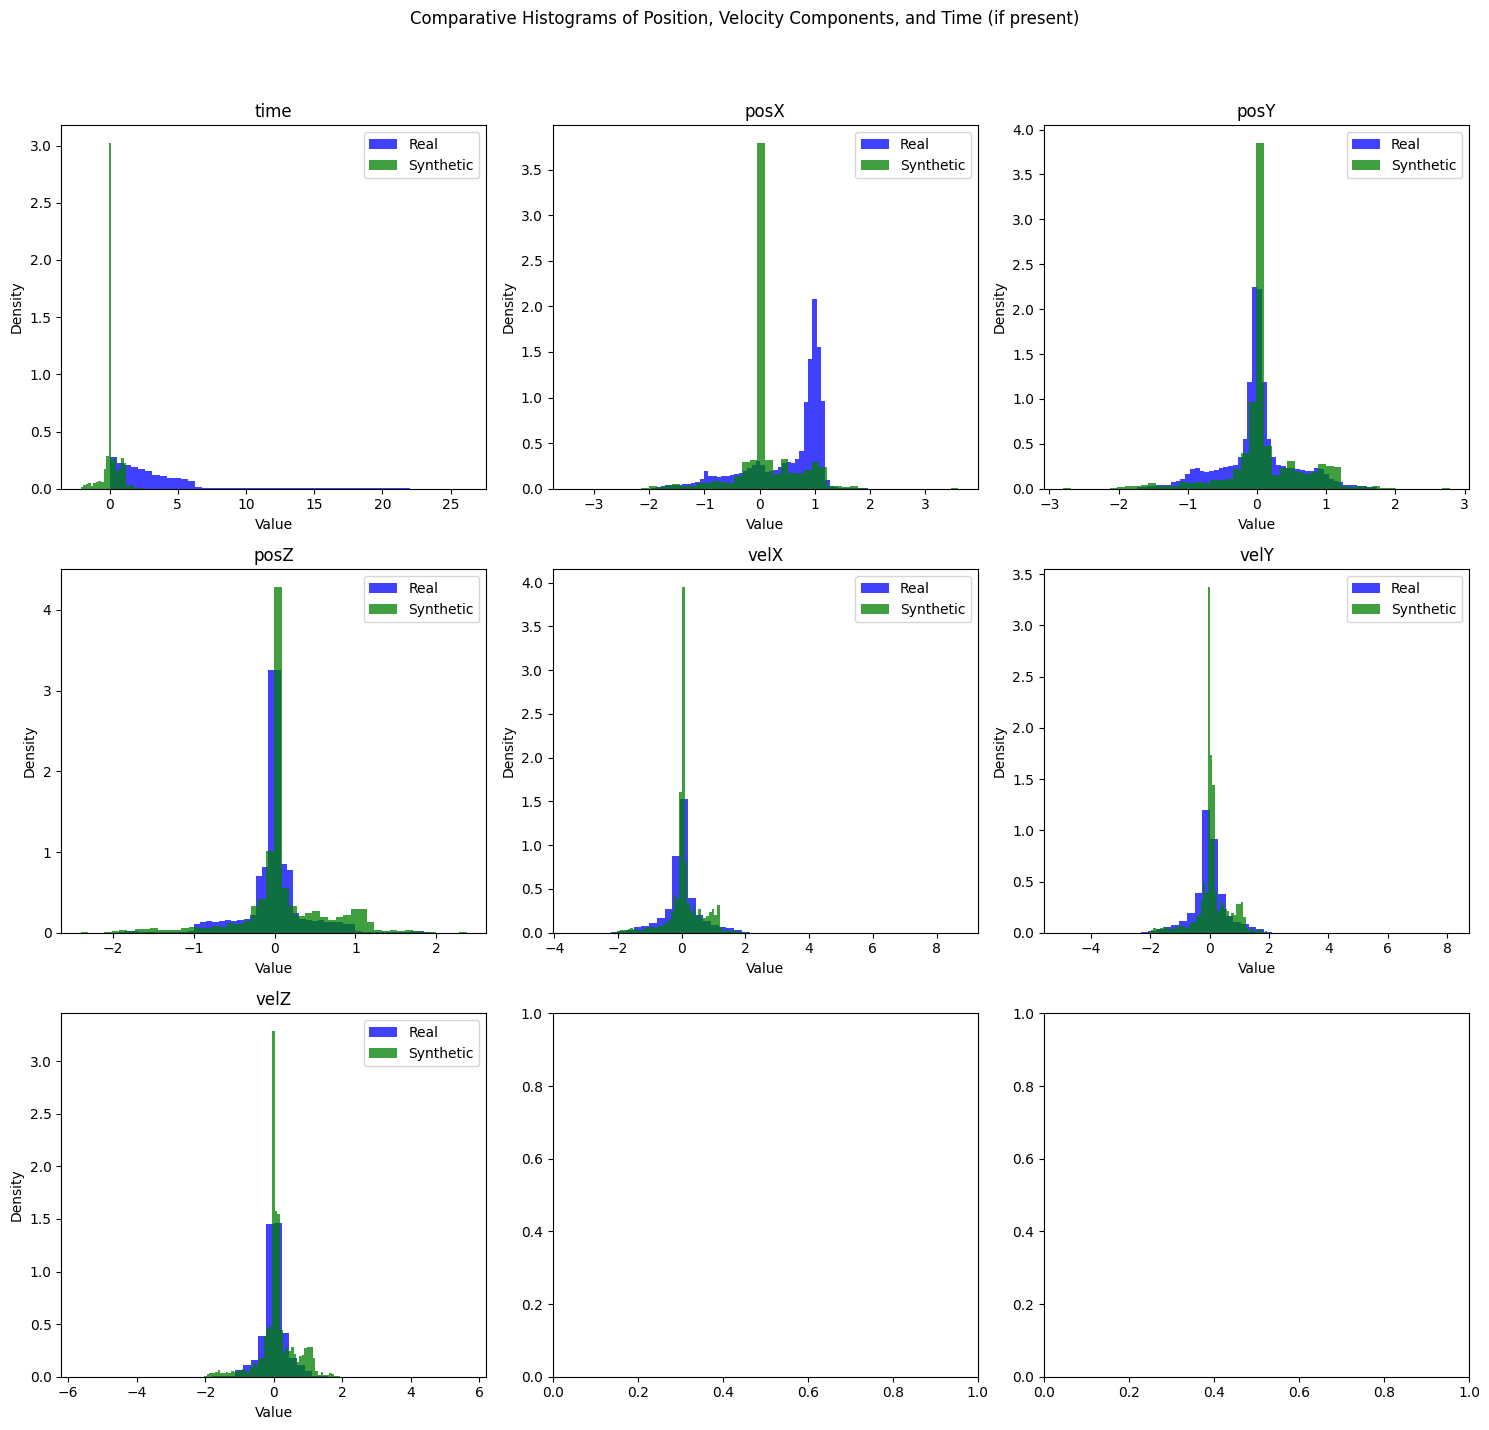

In [23]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Latent Visualization

In [24]:
np.random.seed(42)

# Number of samples to draw
num_samples = 1000

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=num_samples, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(1000, 300, 7)

In [25]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(sampled_data)
latent_representations = latent_mean.numpy()
latent_representations.shape

(1000, 32)

In [26]:
latent_space_path = os.path.join(experiment_folder, 'latent_space')
combined_latent_space_path = os.path.join(experiment_folder, 'combined_latent_space')

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_PCA.png


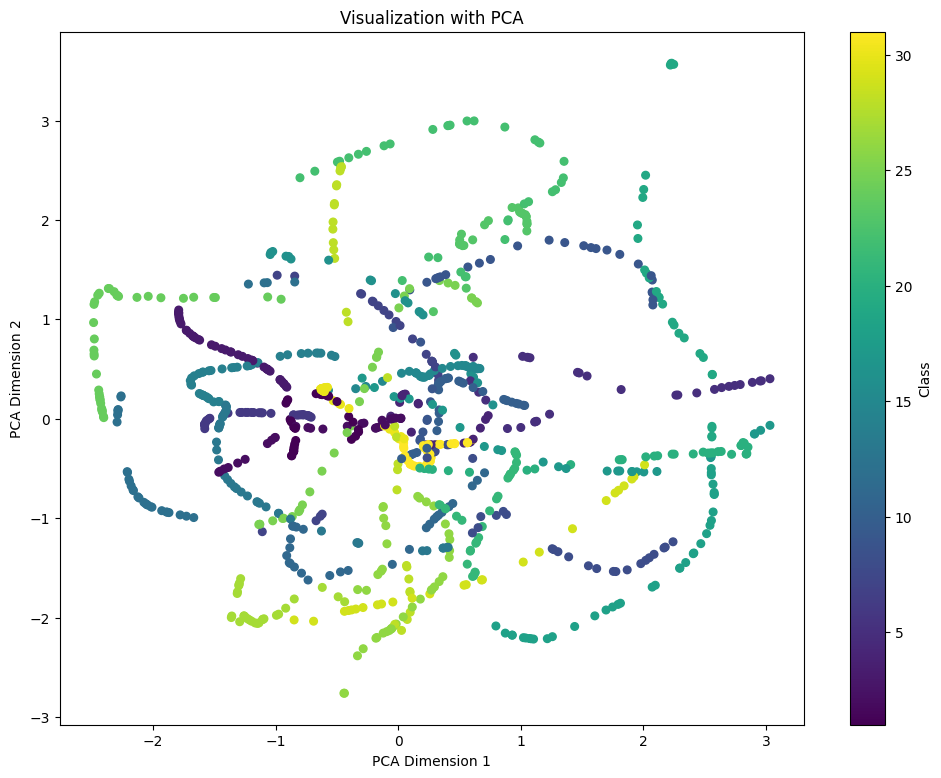

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_t-SNE.png


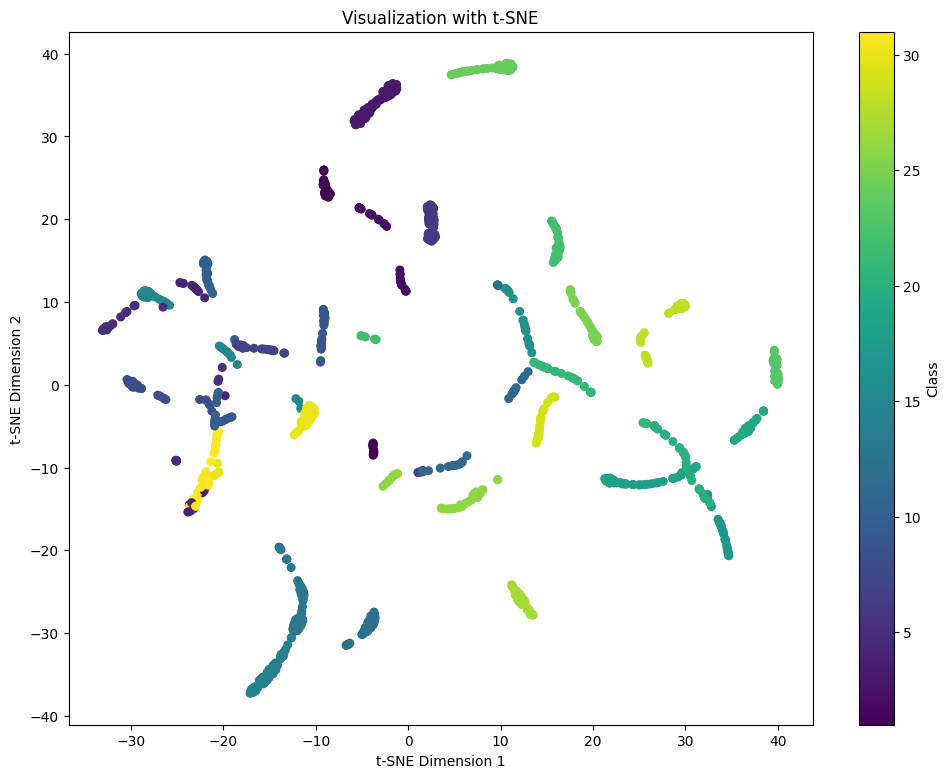

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_UMAP.png


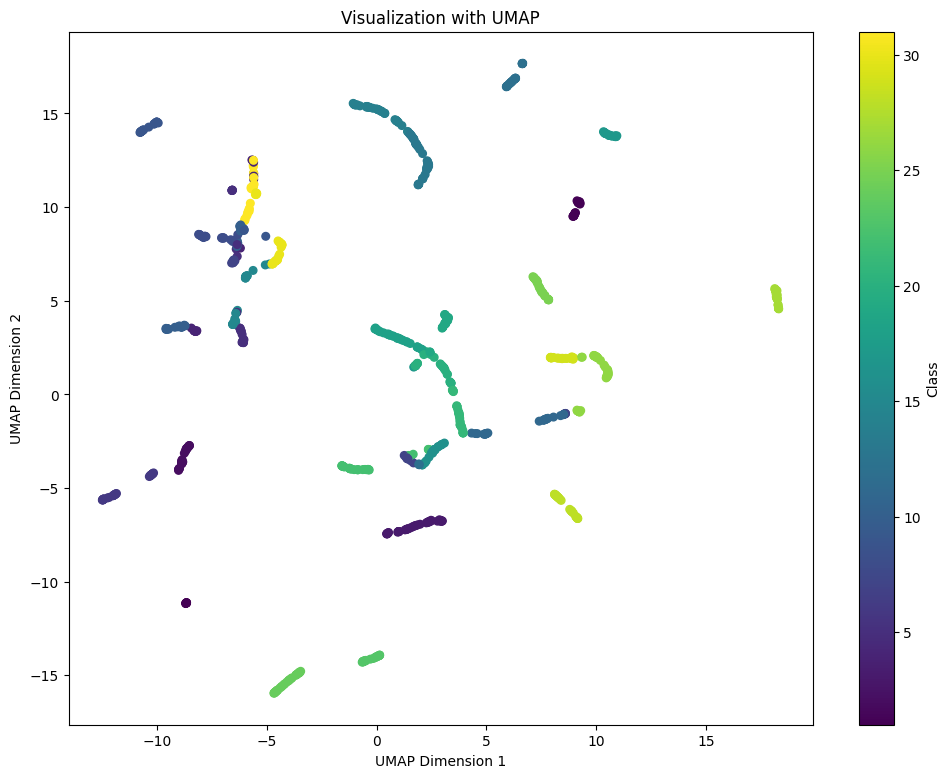

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_LDA.png


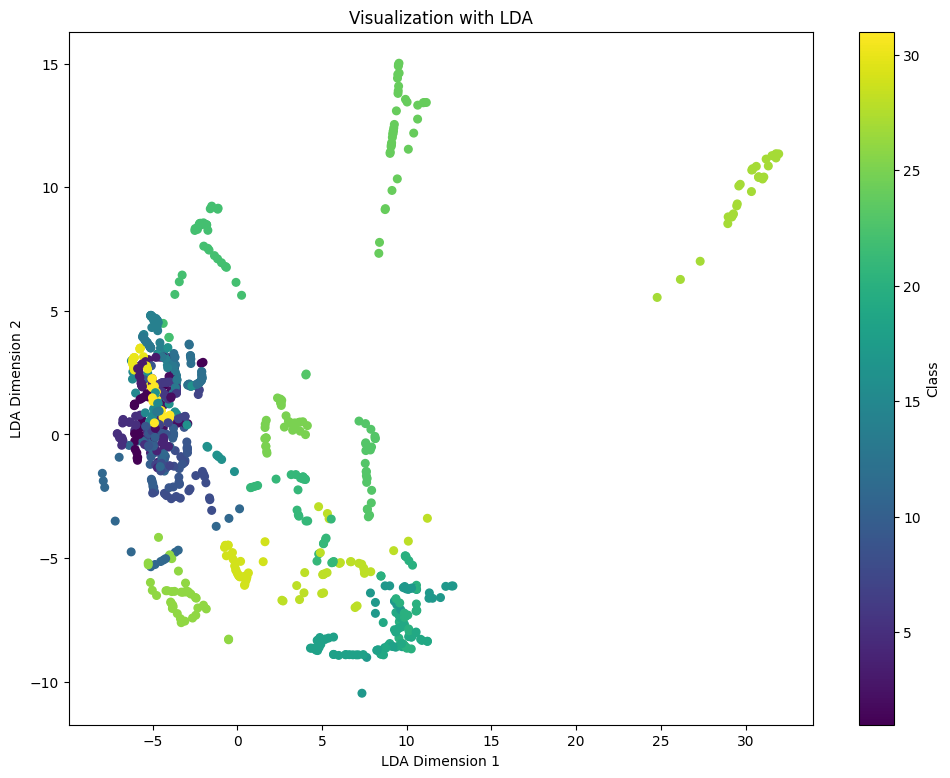

In [27]:
plot_latent_space(latent_representations, sampled_labels, techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path)

In [28]:
sampled_data.shape

(1000, 300, 7)

In [29]:
generation.shape

(100, 300, 7)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap
from typing import List, Any, Dict, Optional

def plot_combined_latent_space(
        real_data: np.ndarray,                # Real data samples.
        synthetic_data: np.ndarray,           # Synthetic data samples generated by a model.
        real_labels: np.ndarray,              # Labels for the real data samples.
        encoder,                              # Encoder function or model that predicts latent space representations.
        techniques: List[str] = ['PCA'],      # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
        n_components: int = 2,                # Number of dimensions to reduce to.
        figsize: tuple = (12, 9),             # Size of the figure for each subplot.
        real_colors: Optional[List[str]] = None,   # Optional list of colors for the real data labels. If None, use random colors.
        synthetic_color: str = 'red',         # Color for the synthetic data points.
        save_path: Optional[str] = None,      # Optional path to save the plot image.
        **kwargs: Any                         # Additional keyword arguments for dimensionality reduction methods.
    ) -> None:
    """
    Plots the combined latent space of real and synthetic data using specified dimensionality reduction techniques.
    The real data points are colored according to their labels, and the synthetic data points are overlaid in a new color.
    """
    # Concatenate real and synthetic data
    combined_data = np.concatenate([real_data, synthetic_data], axis=0)

    # Create labels for real and synthetic data
    synthetic_labels = np.full(synthetic_data.shape[0], -1, dtype=int)  # Use -1 to distinguish synthetic data
    combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

    # Generate latent representations for the combined dataset
    latent_outputs = encoder.predict(combined_data)
    latent_representations = latent_outputs[0]  # Assuming the mean of the latent space is the first output

    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    for technique in techniques:
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, combined_labels)
        else:
            results = model.fit_transform(latent_representations)

        fig = plt.figure(figsize=figsize)
        if n_components == 1:
            ax = fig.add_subplot(111)
            real_data_points = ax.scatter(results[:real_data.shape[0]], np.zeros(real_data.shape[0]), c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:], np.zeros(synthetic_data.shape[0]), c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Component 1')
        elif n_components == 2:
            ax = fig.add_subplot(111)
            real_data_points = ax.scatter(results[:real_data.shape[0], 0], results[:real_data.shape[0], 1], c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:, 0], results[real_data.shape[0]:, 1], c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
        elif n_components == 3:
            ax = fig.add_subplot(111, projection='3d')
            real_data_points = ax.scatter(results[:real_data.shape[0], 0], results[:real_data.shape[0], 1], results[:real_data.shape[0], 2], c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:, 0], results[real_data.shape[0]:, 1], results[real_data.shape[0]:, 2], c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
            ax.set_zlabel(f'{technique} Dimension 3')

        ax.set_title(f'Visualization with {technique}')
        plt.legend()
        if save_path:
            individual_save_path = f"{save_path}_{technique}.png"
            plt.savefig(individual_save_path)
            print(f"Saved plot to {individual_save_path}")
        plt.show()


35/35 [==============================] - 1s 10ms/step


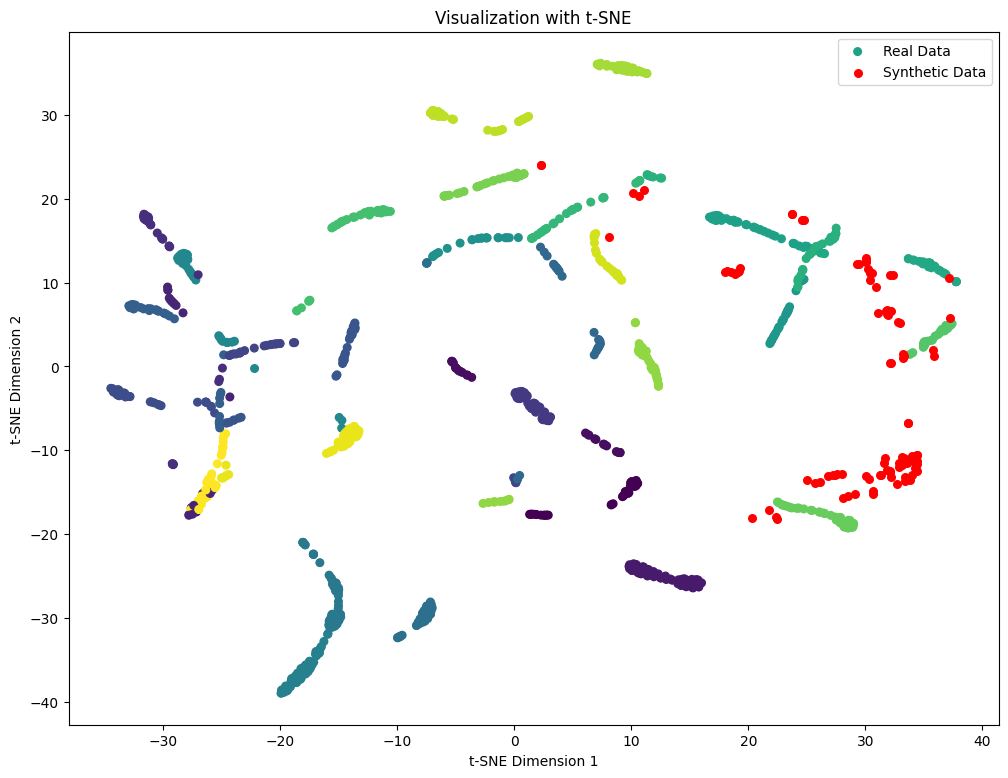

In [36]:
plot_combined_latent_space(sampled_data, generation, sampled_labels, encoder, ['t-SNE'])

In [34]:
sampled_data.shape

(1000, 300, 7)

In [35]:
generation.shape

(100, 300, 7)

In [33]:
plot_combined_latent_space(sampled_data, generation, encoder, ['PCA','t-SNE','UMAP'], save_path=combined_latent_space_path)

ValueError: zero-dimensional arrays cannot be concatenated

In [42]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
kl_loss,█▇▆▅▃▃▃▃▂▂▂▁▂▁▁▁▂▁▂▂▁▁▁▂▁
loss,█▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
kl_loss,10.70042
loss,20.29341
reconstruction_loss,9.59131
